# Extracting Data About CryoSPARC Projects

Some use cases require programmatic access of information about a CryoSPARC instance or job.
For example, an Electronic Lab Notebook may require knowing the project and job UIDs associated with a particular map, and the final GSFSC resolution, mask, and particle stack used to create it.
Other cases may use an external database to associate e.g., the process used to purify protein with the final map quality for that prep.

This type of use, while important, is very context-specific, so no one-size-fits-all approach will exist.
However, the notebooks in this directory provide some guidance on how information like this may be extracted.
Functions and steps used in these notebooks could be combined into a script which is run on jobs of interest from the command line.

- The refinement type
- Symmetry applied
- Number of particles
- Diagnostic information about the map quality
- Paths to maps, half maps, and masks

We will build a function, called `get_map_info()`, piece by piece in this notebook in individual cells.
At the end of the notebook, the entire function is displayed for use in other scripts.

## Connecting to the CryoSPARC instance
First, we load the necessary libraries and establish a connection to the CryoSPARC instance.
This would happen outside the function, typically at the beginning of a script.

In [46]:
from cryosparc.tools import CryoSPARC
import json
from pathlib import Path

with open(Path("~/dev2-info.json").expanduser(), "r") as f:
    instance_info = json.load(f)

cs = CryoSPARC(**instance_info)
assert cs.test_connection()

Connection succeeded to CryoSPARC command_core at http://cryoem0.sbi:42002
Connection succeeded to CryoSPARC command_vis at http://cryoem0.sbi:42003
Connection succeeded to CryoSPARC command_rtp at http://cryoem0.sbi:42005


## Basic job information and map paths

Basic information about the job is available from the [job object](https://tools.cryosparc.com/api/job.html), and map/mask paths are available from the [volume dataset](https://tools.cryosparc.com/api/dataset.html).
To load the volume dataset, we'll need the output group's name.
Output group names are visible in a small box in the output (`volume` in this case).

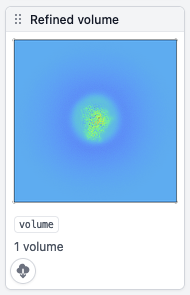

In [47]:
project_uid = "P30"
job_uid = "J180"
volume_title = "volume"

project = cs.find_project(project_uid)
job = project.find_job(job_uid)
vol_data = job.load_output(volume_title)

`vol_data` is a dataset containing the volume's metadata.
Datasets have fields (you can think of these like columns) and rows.
Refinements only produce one voume, so their volume datasets only have one row.

In [48]:
# printing just to show what's in the vol_data object, this is not a necessary step of the analysis
longest_field = max(len(field) for field in vol_data.fields())
for field in vol_data.fields():
    print(field.rjust(longest_field), vol_data[field][0], sep = ": ")

                  uid: 802514353316584297
             map/path: J180/J180_009_volume_map.mrc
            map/shape: [350 350 350]
          map/psize_A: 0.96814287
       map_sharp/path: J180/J180_009_volume_map_sharp.mrc
      map_sharp/shape: [350 350 350]
    map_sharp/psize_A: 0.96814287
      map_half_A/path: J180/J180_009_volume_map_half_A.mrc
     map_half_A/shape: [350 350 350]
   map_half_A/psize_A: 0.96814287
      map_half_B/path: J180/J180_009_volume_map_half_B.mrc
     map_half_B/shape: [350 350 350]
   map_half_B/psize_A: 0.96814287
     mask_refine/path: J180/J180_009_volume_mask_refine.mrc
    mask_refine/shape: [350 350 350]
  mask_refine/psize_A: 0.96814287
        mask_fsc/path: J180/J180_009_volume_mask_fsc.mrc
       mask_fsc/shape: [350 350 350]
     mask_fsc/psize_A: 0.96814287
   mask_fsc_auto/path: J180/J180_009_volume_mask_fsc_auto.mrc
  mask_fsc_auto/shape: [350 350 350]
mask_fsc_auto/psize_A: 0.96814287
       precision/path: J180/J180_009_volume_precision.

Field names all take the form of `{prefix}/{suffix}`, where `prefix` is the output name and `suffix` is the field within that output.
You can see here that the `volume` output group has several different outputs (`map`, `map_sharp`, `map_half_A`, etc.) and that each output contains several fields which provide information about that output.
This structure mirrors the structure of the outputs tab of the CryoSPARC GUI:

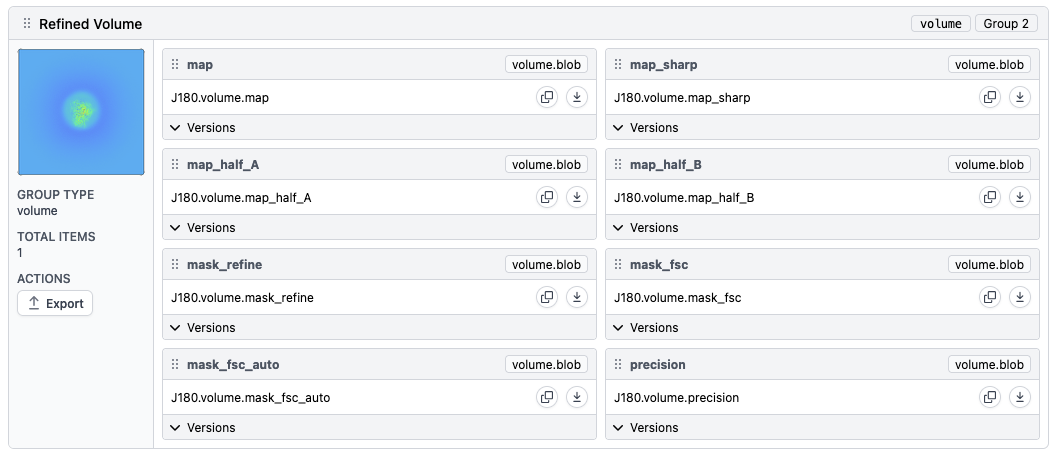

This dataset gives us paths, box sizes, and pixel sizes. Let's start constructing our eventual JSON object.
We'll convert all of these paths to absolute paths so that they can be used to download maps using tools like `scp`.
Here we take advantage of [`project.dir()`](https://tools.cryosparc.com/api/project.html#cryosparc.project.Project.dir), which returns a [Path object](https://docs.python.org/3/library/pathlib.html) for the absolute path to the project's root directory.
That makes it easy to construct absolute paths for anything produced by the project.

In [49]:
# excluding precision b/c it's not often useful
path_field_names = [f for f in vol_data.fields() if f.endswith("path") and f != "precision/path"]

# js will be our eventual JSON object
js = {
    "psize_A": float(vol_data["map/psize_A"][0]),
    "box_size_vox": int(vol_data["map/shape"][0][0])
}

paths = {
    # path_name.split("/")[0] removes the suffix from the field name
    path_name.split("/")[0]: str(project.dir() / vol_data[path_name][0])
    for path_name in path_field_names
}
js["paths"] = paths

# pprint not necessary for analysis
from pprint import pprint
pprint(js)

{'box_size_vox': 350,
 'paths': {'map': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_map.mrc',
           'map_half_A': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_map_half_A.mrc',
           'map_half_B': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_map_half_B.mrc',
           'map_sharp': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_map_sharp.mrc',
           'mask_fsc': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_mask_fsc.mrc',
           'mask_fsc_auto': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_mask_fsc_auto.mrc',
           'mask_refine': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_mask_refine.mrc'},
 'psize_A': 0.9681428670883179}


Don't worry about the `np.float32()` -- those will be removed when we eventually save the JSON object.

## Job info and parameters
Some job information is available directly from the job object:

In [50]:
job_info = {
    "puid": project_uid,
    "juid": job_uid,
    "type": job.type,
}

pprint(job_info)

{'juid': 'J180', 'puid': 'P30', 'type': 'nonuniform_refine_new'}


However, a lot of information is only available in the job's `doc`.
This is a large dictionary associated with each job that contains a ton of information, including:
 - Default parameter settings
 - Which parameters were changed, and what they were changed to
 - Information about inputs and outputs
 - GSFSC resolution and other metrics

<style>
.callout {
    padding-inline: 4em;
    padding-block: 1em;
    width: 80%;
    margin: auto;
    display: flex;
    align-items: center;
    gap: 1em;
}
</style>

<div class="callout" style="background-color: #E4766E55; ">
    <svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 256 256" width="25">
        <rect width="256" height="256" fill="none"/>
        <circle cx="128" cy="128" r="96" fill="none" stroke="currentColor" stroke-miterlimit="10" stroke-width="16"/>
        <line x1="128" y1="136" x2="128" y2="80" fill="none" stroke="currentColor" stroke-linecap="round" stroke-linejoin="round" stroke-width="16"/>
        <circle cx="128" cy="172" r="12"/>
    </svg>
    <p style="margin: 0;">
        The job doc is currently an unstable feature, and scripts using it may break without warning.
        This script was written for CryoSPARC v4.7.1.
    </p>
</div>

There are a few ways to start looking for job information using the job doc.
The Metadata tab of the CryoSPARC GUI is often the best place to start.

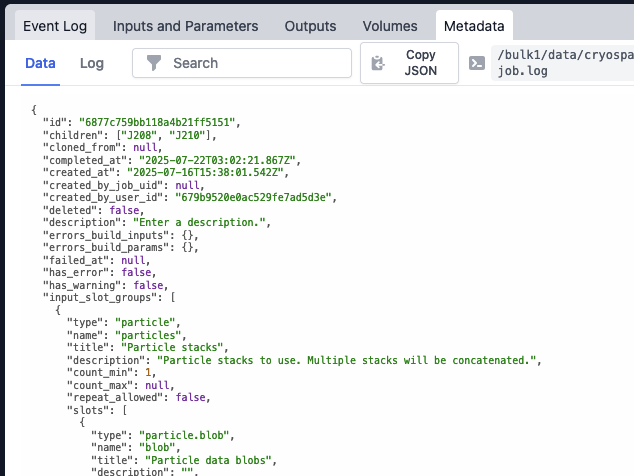

This tab has the same structure as the job doc, and is searchable.

It's also sometimes helpful to view the list of keys for a given level of the job doc, especially if you have a particular word you're looking for:

In [51]:
for key in job.doc.keys():
    if "input" in key:
        print(key)

errors_build_inputs
input_slot_groups
no_check_inputs_ready


Using a combination of these methods, we can find the number of particles in the output result groups:

In [52]:
job_info["particle_count"] = job.doc["output_result_groups"][0]["num_items"]

<style>
.callout {
    padding-inline: 4em;
    padding-block: 1em;
    width: 80%;
    margin: auto;
    display: flex;
    align-items: center;
    gap: 1em;
}
</style>
<div class="callout" style="background-color: #0E2E6122">
    <p style="margin: 0;">Note that we could also have loaded the `particles` output dataset and counted the rows, but loading large datasets is slow.</p>
</div>

Similarly, we find that parameters are stored in two places.
Default values for *all* parameters are stored in `params_base`, while user-specified parameters are stored in `params_spec`.
Thus, to get the parameter value used for the job, we should first check whether it's in `params_spec`.
If it is, we should use the value there.
If it's not, we should take the default value from `params_base`.

In [53]:
def get_param(job_doc, param_name):
    if param_name in job_doc["params_spec"]:
        return job_doc["params_spec"][param_name]["value"]
    else:
        return job_doc["params_base"][param_name]["value"]

# the code names of parameters can be found by clicking the parameter in the
# CryoSPARC GUI of a finished job
job_info["parameters"] = {}
for parameter_name in ["refine_symmetry", "refine_relax_symmetry"]:
    job_info["parameters"][parameter_name] = get_param(job.doc, parameter_name)

This is all the information we want about this particular job, so we can add the job_info to the `js` dict.

In [54]:
js["job_info"] = job_info
pprint(js)

{'box_size_vox': 350,
 'job_info': {'juid': 'J180',
              'parameters': {'refine_relax_symmetry': 'none',
                             'refine_symmetry': 'C1'},
              'particle_count': 656974,
              'puid': 'P30',
              'type': 'nonuniform_refine_new'},
 'paths': {'map': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_map.mrc',
           'map_half_A': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_map_half_A.mrc',
           'map_half_B': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_map_half_B.mrc',
           'map_sharp': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_map_sharp.mrc',
           'mask_fsc': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_mask_fsc.mrc',
           'mask_fsc_auto': '/bulk1/data/cryosparcdev2

The last piece of the puzzle is the GSFSC resolution. This is stored as a *summary stat*, which can also be found in the job doc. Currently, the layout of the summary stats are not documented, but you can find them by manually inspecting the job doc. The GSFSC can be found in the volume `output result group`'s summary stats. Note that not all output groups have summary stats associated with them.

In [55]:
for org in job.doc["output_result_groups"]:
    print(org["name"])
    print(f"    {org['name']} result group", "has" if "latest_summary_stats" in org else "does not have", "summary stats")
    for output_result in org["contains"]:
        print(f"    {org['name']} result group contains result:", output_result["name"])

particles
    particles result group does not have summary stats
    particles result group contains result: alignments3D
    particles result group contains result: ctf
    particles result group contains result: blob
    particles result group contains result: motion
    particles result group contains result: location
    particles result group contains result: pick_stats
volume
    volume result group has summary stats
    volume result group contains result: map
    volume result group contains result: map_sharp
    volume result group contains result: map_half_A
    volume result group contains result: map_half_B
    volume result group contains result: mask_refine
    volume result group contains result: mask_fsc
    volume result group contains result: mask_fsc_auto
    volume result group contains result: precision
mask
    mask result group does not have summary stats
    mask result group contains result: mask_refine


In [56]:
js["gsfsc"] = f"{job.doc["output_result_groups"][1]["latest_summary_stats"]["fsc_info_best"]["radwn_final_A"]:1.2f}"
pprint(js)

{'box_size_vox': 350,
 'gsfsc': '2.28',
 'job_info': {'juid': 'J180',
              'parameters': {'refine_relax_symmetry': 'none',
                             'refine_symmetry': 'C1'},
              'particle_count': 656974,
              'puid': 'P30',
              'type': 'nonuniform_refine_new'},
 'paths': {'map': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_map.mrc',
           'map_half_A': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_map_half_A.mrc',
           'map_half_B': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_map_half_B.mrc',
           'map_sharp': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_map_sharp.mrc',
           'mask_fsc': '/bulk1/data/cryosparcdev2_projects/CS-ks-gastric-proton-pump-automation/J180/J180_009_volume_mask_fsc.mrc',
           'mask_fsc_auto': '/bulk1/

With this, we have extracted all of the relevant information for this job, so we can save it to a JSON file which other programs can read.

In [57]:
with open(f"{project_uid}-{job_uid}.json", "w") as f:
    json.dump(js, f)